In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Load some colormaps (if needed):

cmap_dirs = [x for x in os.listdir('/home/leachl/Downloads/ScientificColourMaps5/') if not '.' in x and not '+' in x]
cmaps = {}
for cmapname in cmap_dirs:
    cm_data = np.loadtxt('/home/leachl/Downloads/ScientificColourMaps5/'+cmapname+'/'+cmapname+'.txt')
    cmaps[cmapname] = matplotlib.colors.LinearSegmentedColormap.from_list(cmapname, cm_data)

In [2]:
HIST_forc_PF = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=3,sep='\t',index_col=0).apply(pd.to_numeric)
HIST_forc_PF.iloc[-3:,:] = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=271,header=None,delim_whitespace=True,index_col=0).values
HIST_forc_PF = HIST_forc_PF.set_index(np.arange(1750,2020))
HIST_forc_PF['Natural total'] = HIST_forc_PF['Total'] - HIST_forc_PF['Anthro total']

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


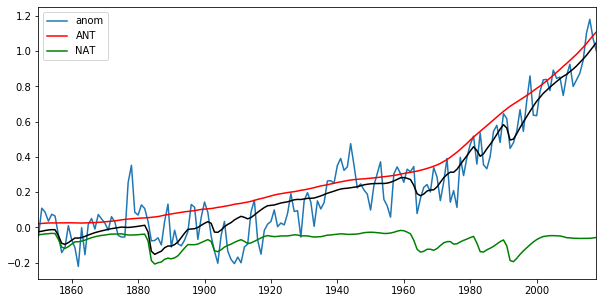

In [3]:
## Get 4 dataset mean temps:

base_fname = '/home/leachl/Documents/Datasets/GMST/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/HadCRUT.4.6.0.0.monthly_ns_avg.'

HadCRUT4_ens_df = pd.DataFrame(index = np.arange(1850+1/12,2019+4/12+0.001,1/12)-1/24,columns = np.arange(1,101))

for i in np.arange(1,101):
    member = str(i)
    fname = base_fname + member + '.txt'
    hadcrut_mem_df = pd.read_csv(fname,sep='   ',header=None)
    temps = hadcrut_mem_df[1].values
    HadCRUT4_ens_df.loc[:,i] = temps
    
temp_base = '/home/leachl/Documents/Datasets/GMST'
CW_temps = pd.read_csv(temp_base+'/CW_had4_krig_v2_0_0.txt',delim_whitespace=True,header=None,index_col=0,names=['Year','anom','tot_uc','cov_uc','ens_uc']).set_index(HadCRUT4_ens_df.index[:-1]).anom
NOAA_temps = pd.read_csv(temp_base+'/NOAA_1880-2019.csv',skiprows=4,index_col=0).set_index(HadCRUT4_ens_df.loc[1880:].index).Value
GISS_temps = pd.read_csv(temp_base+'/nasa_GLB.Ts+dSST.txt',skiprows=7,delim_whitespace=True,index_col=0).iloc[:2019,:12]
GISS_temps = GISS_temps.loc[:'2019'].loc[GISS_temps.loc[:'2019'].index != "Year"].values.flatten()[:-8]
GISS_temps = pd.Series(GISS_temps.astype(float),index = NOAA_temps.index)/100
ALL_temps = pd.DataFrame(index = HadCRUT4_ens_df.index,columns=['anom'])
HC_mem = HadCRUT4_ens_df.median(axis=1)
HC_mem = HC_mem - HC_mem.loc[1850:1900].mean()
CW_mem = CW_temps - CW_temps.loc[1850:1900].mean()
NOAA_mem = NOAA_temps - (NOAA_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
GISS_mem = GISS_temps - (GISS_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
ALL_temps.loc[:,'anom'] = (1/4)*(HC_mem+CW_mem+NOAA_mem+GISS_mem)
ALL_temps.loc[1850:1880,'anom'] = (1/2)*(HC_mem.loc[1850:1880]+CW_mem.loc[1850:1880])
ALL_temps = ALL_temps.loc[:2019]
Annual_4_set_GMST = ALL_temps.rolling(12).mean().iloc[11::12].set_index(np.arange(1850,2019))
                                                                        
fig,ax = plt.subplots(figsize=(10,5))
Annual_4_set_GMST.plot(ax=ax)

def convert_forc_to_model_input(forcing,scen_name,inner_name='forcing'):
    return pd.concat([pd.DataFrame(forcing.rename(inner_name))],axis=1,keys=[scen_name])

Attr_thermal_params = default_thermal_params()
Attr_thermal_params.loc['tcr_ecs'] = [1.6,2.8]

ANT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

NAT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Natural total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

Y = Annual_4_set_GMST.copy()
X = pd.concat([ANT_temps.rename('ANT'),NAT_temps.rename('NAT')],axis=1)
X = sm.add_constant(X)

regression_model = sm.OLS(Y,X.loc[Y.index])
regression_results = regression_model.fit()
(regression_results.params*X.loc[Y.index])[['ANT','NAT']].plot(ax=ax,color=['r','g'])
(regression_results.params*X.loc[Y.index]).sum(axis=1).plot(ax=ax,color='k')

## Attributable warming:

Attributable_warming = (regression_results.params*X).sum(axis=1) - (regression_results.params*X).sum(axis=1).iloc[0]

In [38]:
# Attr_thermal_params

## CMIP6 timescales are 0.952, 10.5, 308
## short timescale q value = 0.263
## need to calculate q1,q2: q1 = 0.159 , q2 = 0.315

d = np.array([0.952,10.5,308])
q = np.array([0.263,0.15014688802543275,0.32385311197456723])

In [51]:
three_tau_params = pd.DataFrame(columns=[1,2,3],index=['d','q'])

three_tau_params.index = three_tau_params.index.rename('param_name')

three_tau_params.columns = three_tau_params.columns.rename('Box')

three_tau_params = pd.concat([three_tau_params],keys=['three_tau'],axis=1)

three_tau_params.loc['d',('three_tau')] = d[::-1]
three_tau_params.loc['q',('three_tau')] = q[::-1]


param_timescales = {}

param_timescales[2] = tcr_ecs_to_q(Attr_thermal_params)
param_timescales[3] = three_tau_params.apply(pd.to_numeric)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


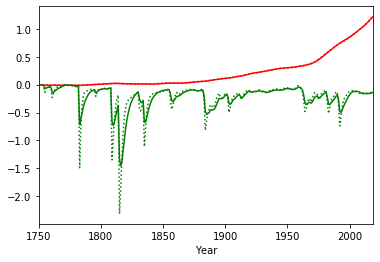

In [57]:
simul_warming = {}
regr_results = {}
linestyles={2:'-',3:':'}

for i in [2,3]:
    
    simul_warming[i] = {}
    
    ANT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming'),\
                    thermal_parameters=param_timescales[i])['T'].iloc[:,0]

    NAT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                         forcing_in=convert_forc_to_model_input(HIST_forc_PF['Natural total'],'Attr_warming'),\
                        thermal_parameters=param_timescales[i])['T'].iloc[:,0]
    
    simul_warming[i]['ANT'] = ANT_temps
    simul_warming[i]['NAT'] = NAT_temps

    Y = Annual_4_set_GMST.copy()
    X = pd.concat([ANT_temps.rename('ANT'),NAT_temps.rename('NAT')],axis=1)
    X = sm.add_constant(X)

    regression_model = sm.OLS(Y,X.loc[Y.index])
    regression_results = regression_model.fit()
    
    regr_results[i] = regression_results
    
    (regression_results.params*X.loc[Y.index])[['ANT','NAT']].plot(ax=ax,color=['r','g'])
    (regression_results.params*X.loc[Y.index]).sum(axis=1).plot(ax=ax,color='k')
    
    ANT_temps.plot(color='r',linestyle=linestyles[i])
    NAT_temps.plot(color='g',linestyle=linestyles[i])

In [60]:
regr_results[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   anom   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     661.0
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           8.73e-80
Time:                        10:16:48   Log-Likelihood:                 141.90
No. Observations:                 169   AIC:                            -277.8
Df Residuals:                     166   BIC:                            -268.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.018     -0.235      0.814      -0.041       0.032
ANT            0.9233      0.026     36.022      0.000       0.873       0.974
NAT            0.3905      0.073      5.345      0.000       0.246       0.535
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.548   Jarque-Bera (JB):                0.834
Skew:                          -0.042   Prob(JB):                        0.659
Kurtosis:                       3.333   Cond. No.                         9.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
regr_results[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   anom   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     637.2
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           1.31e-78
Time:                        10:16:55   Log-Likelihood:                 139.14
No. Observations:                 169   AIC:                            -272.3
Df Residuals:                     166   BIC:                            -262.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0234      0.017     -1.391      0.166      -0.057       0.010
ANT            0.9233      0.026     35.349      0.000       0.872       0.975
NAT            0.3057      0.063      4.874      0.000       0.182       0.430
==============================================================================
Omnibus:                        1.491   Durbin-Watson:                   0.998
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.130
Skew:                          -0.064   Prob(JB):                        0.569
Kurtosis:                       3.380   Cond. No.                         8.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""